<a href="https://colab.research.google.com/github/superIvvvy/DemandSense_WalmartSalesForecastingApp/blob/main/Copy_of_DemandSense_MVP_M5_Forecasting_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DemandSense — Walmart Sales Forecasting App (MVP)
**Final Assignment — Shark Tank (Time Series App) | Colab-Ready Notebook**

**Team:** DemandSense  
**Date:** 2025-09-30

This notebook demonstrates an MVP for DemandSense — a lightweight, interpretable, and accurate demand forecasting tool for Walmart suppliers, category managers, and inventory planners. It uses the **M5 Forecasting (Walmart) dataset** and implements:
- Kaggle API integration (to download data reproducibly)
- Data prep & feature engineering
- EDA and holiday/promo effect exploration
- Baselines (Naive, Seasonal-Naive)
- Classical models (Auto-ARIMA)
- ML model (LightGBM; Prophet optional)
- Rolling-origin backtesting with metrics (MAPE, RMSE)
- Business insights + story for the pitch

> **Use Case:** Predict daily SKU x store demand to reduce stockouts, cut overstocks, and optimize promotions/holidays planning.

> **Data:** https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview

## Instructions
1. Run the Setup cell to install libraries and authenticate with Kaggle (you'll upload your `kaggle.json`).  
2. Run Data Download & Load cells — all M5 files will be downloaded and unzipped.  
3. Proceed through EDA, Modeling, and Backtesting.  
4. Customize as needed (e.g., choose SKUs/stores, adjust model parameters).

> Runtime note: The full M5 dataset is large. For fast iteration in class, we sample a manageable subset (e.g., a few stores x a few categories). You can scale up later.

## 1) Environment Setup & Kaggle API

In [ ]:
import os, sys, platform, gc, itertools, math, random, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 120)
warnings.filterwarnings('ignore')

In [ ]:
# Install packages (Colab)
!pip -q install kaggle lightgbm prophet pmdarima statsmodels pyarrow

# Kaggle API: Upload kaggle.json (from your Kaggle account)
from google.colab import files
print('Please upload your kaggle.json (Account > Create New API Token)')
uploaded = files.upload()  # Expecting kaggle.json

if 'kaggle.json' not in uploaded:
    raise RuntimeError('kaggle.json was not uploaded. Please run this cell again and upload the file.')

# Configure Kaggle API credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle works
!kaggle competitions list | head -n 5


Please upload your kaggle.json (Account > Create New API Token)


Saving kaggle.json to kaggle.json
ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd       1013           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-rules                 2025-10-24 06:59:00  Featured           100,000 Usd       1971           False  
https://www.kaggle.com/competitions/mitsui-commodity-prediction-challenge        2025-10-06 23:59:00  Featured           100,000 Usd       1571           False  


In [ ]:
# === Reproducibility & Config ===

SEED = 42
CFG = {
    "HORIZON": 28,
    "N_FOLDS_DEMO": 3,
    "N_FOLDS_BATCH": 2,
    "SEASON": 7,
    "SAMPLE_STORES": 2,
    "SAMPLE_ITEMS": 30,   # fast iteration; change for full run
}

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_seed(SEED)

def env_report():
    try:
        import lightgbm, pmdarima, prophet, statsmodels
        pkgs = {
            "python": sys.version.split()[0],
            "platform": platform.platform(),
            "pandas": pd.__version__,
            "numpy": np.__version__,
            "lightgbm": lightgbm.__version__,
            "pmdarima": pmdarima.__version__,
            "prophet": prophet.__version__ if hasattr(prophet, "__version__") else "installed",
            "statsmodels": statsmodels.__version__,
        }
    except Exception as e:
        pkgs = {"error": str(e)}
    print("ENV:", pkgs)

env_report()
print("Config:", CFG)


ENV: {'error': 'numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject'}
Config: {'HORIZON': 28, 'N_FOLDS_DEMO': 3, 'N_FOLDS_BATCH': 2, 'SEASON': 7, 'SAMPLE_STORES': 2, 'SAMPLE_ITEMS': 30}


## 2) Download M5 Dataset & Unzip

In [ ]:
!kaggle competitions download -c m5-forecasting-accuracy -p /content
!unzip -o -q /content/m5-forecasting-accuracy.zip -d /content/m5_data
!ls -lh /content/m5_data


m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)
total 430M
-rw-r--r-- 1 root root 102K Jun  1  2020 calendar.csv
-rw-r--r-- 1 root root 117M Jun  1  2020 sales_train_evaluation.csv
-rw-r--r-- 1 root root 115M Jun  1  2020 sales_train_validation.csv
-rw-r--r-- 1 root root 5.0M Jun  1  2020 sample_submission.csv
-rw-r--r-- 1 root root 194M Jun  1  2020 sell_prices.csv


## 3) Load Data (calendar, sales, prices)

In [ ]:
DATA_DIR = '/content/m5_data'

calendar = pd.read_csv(f'{DATA_DIR}/calendar.csv')
sell_prices = pd.read_csv(f'{DATA_DIR}/sell_prices.csv')
sales_val = pd.read_csv(f'{DATA_DIR}/sales_train_validation.csv')
sales_eval = pd.read_csv(f'{DATA_DIR}/sales_train_evaluation.csv')

print('calendar:', calendar.shape, '\nsell_prices:', sell_prices.shape)
print('sales_val:', sales_val.shape, '\nsales_eval:', sales_eval.shape)
display(calendar.head(3))
display(sell_prices.head(3))
display(sales_val.head(3))


calendar: (1969, 14) 
sell_prices: (6841121, 4)
sales_val: (30490, 1919) 
sales_eval: (30490, 1947)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1


### Data Dictionary (Quick)
- calendar.csv — date attributes (d keys, events, SNAP flags by state, month/day info)
- sell_prices.csv — price of product by store_id, item_id, wm_yr_wk
- sales_train_validation.csv — daily unit sales per item_id x store_id for days d_1 to d_1913
- sales_train_evaluation.csv — extends to d_1941 (public LB period)

## 4) Reshape Sales (Wide → Long) & Join Calendar

In [ ]:
sample_sales = sales_val[
    (sales_val['dept_id'].isin(['HOBBIES_1','HOBBIES_2'])) &
    (sales_val['state_id'] == 'CA')
]


print(sample_sales.shape)  # should no longer be (0, 1919)
display(sample_sales.head(3))


(2260, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,...,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1,1,0,0,0,2,2,0,0,1,4,0,0,0,0,1,1,2,0,4,0,1,0,1,4,2,0,2,0,1,1,0,1,0,0,1,1,3,0,0,0,1,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,1,1,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1


In [ ]:
id_cols = [c for c in sample_sales.columns if not c.startswith('d_')]
val_long = sample_sales.melt(id_vars=id_cols, var_name='d', value_name='sales')



In [ ]:
val_long = val_long.merge(
    calendar[['date','d','wm_yr_wk','weekday','wday','month','year',
              'event_name_1','event_type_1','event_name_2','event_type_2',
              'snap_CA','snap_TX','snap_WI']],
    on='d', how='left'
)
val_long['date'] = pd.to_datetime(val_long['date'])



In [ ]:
val_long['snap'] = (
    (val_long['state_id'].eq('CA') & val_long['snap_CA'].eq(1)) |
    (val_long['state_id'].eq('TX') & val_long['snap_TX'].eq(1)) |
    (val_long['state_id'].eq('WI') & val_long['snap_WI'].eq(1))
).astype(int)



In [ ]:
val_long = val_long.merge(
    sell_prices, on=['store_id','item_id','wm_yr_wk'], how='inner'
)

val_long.sort_values(['item_id','store_id','date'], inplace=True)
val_long.reset_index(drop=True, inplace=True)

print(val_long.shape)
display(val_long.head(5))


(3429298, 23)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,snap,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_897,0,2013-07-13,11325,Saturday,1,7,2013,NaN,NaN,NaN,NaN,0,1,0,0,9.58
1,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_898,0,2013-07-14,11325,Sunday,2,7,2013,NaN,NaN,NaN,NaN,0,0,1,0,9.58
2,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_899,0,2013-07-15,11325,Monday,3,7,2013,NaN,NaN,NaN,NaN,0,1,1,0,9.58
3,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_900,0,2013-07-16,11325,Tuesday,4,7,2013,NaN,NaN,NaN,NaN,0,0,0,0,9.58
4,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_901,0,2013-07-17,11325,Wednesday,5,7,2013,NaN,NaN,NaN,NaN,0,0,0,0,9.58


In [ ]:
#id_cols = [c for c in sales_val.columns if not c.startswith('d_')]
#val_long = sales_val.melt(id_vars=id_cols, var_name='d', value_name='sales')

#val_long = val_long.merge(calendar[['date','d','wm_yr_wk','weekday','wday','month','year',
#                                   'event_name_1','event_type_1','event_name_2','event_type_2',
#                                  'snap_CA','snap_TX','snap_WI']],
#                          on='d', how='left')
#val_long['date'] = pd.to_datetime(val_long['date'])

#def row_snap(row):
#    if row['state_id'] == 'CA':
#        return row['snap_CA']
#    if row['state_id'] == 'TX':
#        return row['snap_TX']
#    if row['state_id'] == 'WI':
#        return row['snap_WI']
#    return 0

#val_long['snap'] = val_long.apply(row_snap, axis=1).astype(int)

#val_long = val_long.merge(sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left')
#val_long.sort_values(['item_id','store_id','date'], inplace=True)
#val_long.reset_index(drop=True, inplace=True)

#print(val_long.shape)
#display(val_long.head(5))


## 5) Sampling for Fast Iteration

In [ ]:
# Choose 2 stores and 30 random items from the overlap
np.random.seed(123)
stores = val_long['store_id'].unique().tolist()
pick_stores = stores[:2]

subset = val_long[val_long['store_id'].isin(pick_stores)].copy()
item_pool = subset['item_id'].unique().tolist()
sample_items = np.random.choice(item_pool, size=min(30, len(item_pool)), replace=False)
subset = subset[subset['item_id'].isin(sample_items)]

print(subset.shape, subset['item_id'].nunique(), subset['store_id'].nunique())



(94431, 23) 30 2


## 6) EDA — Trends, Holidays, SNAP, Prices

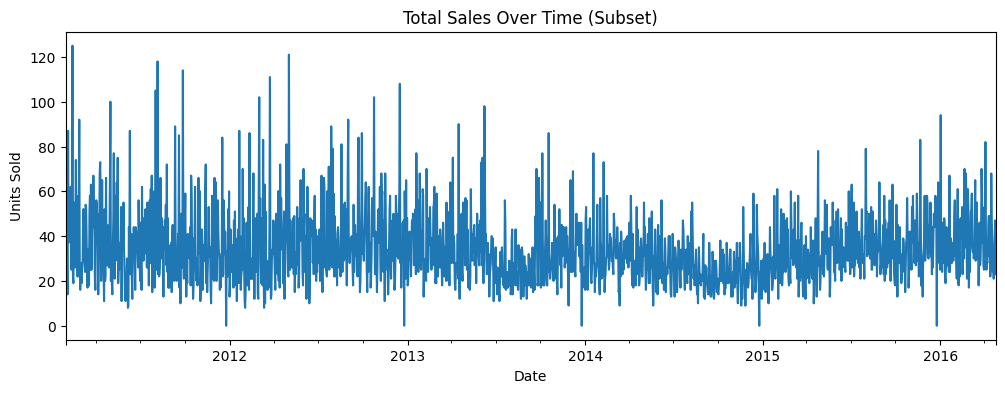

Sample holiday dates:


,date,event_name_1,sales
0,2011-02-06,SuperBowl,40
1,2011-02-14,ValentinesDay,19
2,2011-02-21,PresidentsDay,41
3,2011-03-09,LentStart,28
4,2011-03-16,LentWeek2,34
5,2011-03-17,StPatricksDay,23
6,2011-03-20,Purim End,58
7,2011-04-24,OrthodoxEaster,28
8,2011-04-26,Pesach End,31
9,2011-05-05,Cinco De Mayo,14


Avg sales by SNAP flag (subset):


,sales
snap,
0,0.681338
1,0.706212


Correlation(sell_price, sales) [subset]: -0.135


In [ ]:
# Total sales over time
daily_tot = subset.groupby('date')['sales'].sum()
plt.figure(figsize=(12,4))
daily_tot.plot()
plt.title('Total Sales Over Time (Subset)')
plt.xlabel('Date'); plt.ylabel('Units Sold')
plt.show()

# Holiday effects
holidays = subset[subset['event_name_1'].notna()]
holidays_by_date = holidays.groupby(['date','event_name_1'])['sales'].sum().reset_index()
print('Sample holiday dates:')
display(holidays_by_date.sort_values('date').head(10))

# SNAP effect
snap_agg = subset.groupby('snap')['sales'].mean()
print('Avg sales by SNAP flag (subset):')
display(snap_agg)

# Price correlation
price_corr = subset[['sell_price','sales']].dropna().corr().iloc[0,1]
print(f'Correlation(sell_price, sales) [subset]: {price_corr:.3f}')



## 7) Utilities — Metrics & Rolling-Origin Backtesting

In [ ]:
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.nan

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def rolling_backtest(series, model_func, horizon=28, n_folds=3, **kwargs):
    results = []
    dates = series.index.sort_values()
    total = len(dates)
    fold_size = horizon
    for k in range(n_folds):
        end_idx = total - k*fold_size
        start_idx = end_idx - fold_size
        if start_idx <= 0:
            break
        train = series.iloc[:start_idx]
        test = series.iloc[start_idx:end_idx]
        fc = model_func(train, horizon, **kwargs)
        fc = np.array(fc).reshape(-1)
        test_vals = test.values[:len(fc)]
        results.append({
            'fold': k+1,
            'start': test.index[0],
            'end': test.index[min(len(fc)-1, len(test)-1)],
            'rmse': rmse(test_vals, fc[:len(test_vals)]),
            'mape': mape(test_vals, fc[:len(test_vals)]),
            'y_true': test_vals,
            'y_pred': fc[:len(test_vals)]
        })
    return list(reversed(results))


## 8) Baseline Models — Naive & Seasonal-Naive

In [ ]:
def fc_naive_last(train, horizon=28, **kwargs):
    last_val = train.iloc[-1]
    return np.repeat(last_val, horizon)

def fc_seasonal_naive(train, horizon=28, season=7, **kwargs):
    hist = train.values
    pattern = hist[-season:]
    reps = int(np.ceil(horizon/season))
    return np.tile(pattern, reps)[:horizon]

demo_key = subset.groupby(['item_id','store_id']).size().index[0]
demo_series = subset[(subset['item_id']==demo_key[0]) & (subset['store_id']==demo_key[1])]\
    .set_index('date')['sales'].asfreq('D').fillna(0)
print('Demo series:', demo_key, 'length:', len(demo_series))

naive_res = rolling_backtest(demo_series, fc_naive_last, horizon=28, n_folds=3)
seasonal_res = rolling_backtest(demo_series, fc_seasonal_naive, horizon=28, n_folds=3, season=7)
print('Naive Backtest (3 folds):', [(r['rmse'], r['mape']) for r in naive_res])
print('Seasonal-Naive Backtest (3 folds):', [(r['rmse'], r['mape']) for r in seasonal_res])


Demo series: ('HOBBIES_1_006', 'CA_1') length: 1486
Naive Backtest (3 folds): [(2.1464256001881026, np.float64(100.0)), (1.7627089541790095, np.float64(100.0)), (1.7627089541790095, np.float64(68.5185185185185))]
Seasonal-Naive Backtest (3 folds): [(2.1464256001881026, np.float64(97.47474747474747)), (3.550653863324734, np.float64(184.22222222222223)), (1.8027756377319946, np.float64(66.66666666666666))]


## 9) Classical Models — SARIMAX (statsmodels) as a drop-in for auto_arima

In [ ]:
def _auto_sarimax_order(y,
                        seasonal=True, m=7,
                        max_p=2, max_q=2, max_P=1, max_Q=1,
                        d=1, D=1):
    """
    Lightweight auto-order search by AIC (small, fast grid).
    Returns (order, seasonal_order).
    """
    best_aic = np.inf
    best_order = (0, d, 0)
    best_seasonal = (0, D, 0, m if seasonal else 0)

    Ps = range(max_P + 1) if seasonal else [0]
    Qs = range(max_Q + 1) if seasonal else [0]

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            for P in Ps:
                for Q in Qs:
                    try:
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore")
                            mod = SARIMAX(
                                y,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, m) if seasonal else (0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False
                            )
                            res = mod.fit(disp=False)
                        if res.aic < best_aic:
                            best_aic = res.aic
                            best_order = (p, d, q)
                            best_seasonal = (P, D, Q, m) if seasonal else (0, 0, 0, 0)
                    except Exception:
                        continue
    return best_order, best_seasonal

def fc_auto_arima(train, horizon=28, seasonal=True, m=7,
                  max_p=2, max_q=2, max_P=1, max_Q=1, d=1, D=1, **kwargs):
    """
    Drop-in replacement for pmdarima.auto_arima:
    - Same signature (train, horizon, seasonal, m, **kwargs)
    - Returns a 1D np.array forecast of length = horizon
    """
    y = np.asarray(train, dtype="float64")  # train is a pd.Series
    order, seasonal_order = _auto_sarimax_order(
        y, seasonal=seasonal, m=m,
        max_p=max_p, max_q=max_q, max_P=max_P, max_Q=max_Q,
        d=d, D=D
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mod = SARIMAX(
            y,
            order=order,
            seasonal_order=seasonal_order if seasonal else (0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = mod.fit(disp=False)
        fc = res.forecast(steps=horizon)
    return np.asarray(fc)

arima_res = rolling_backtest(demo_series, fc_auto_arima, horizon=28, n_folds=3, seasonal=True, m=7)
print('Auto-ARIMA Backtest (3 folds):', [(r['rmse'], r['mape']) for r in arima_res])

Auto-ARIMA Backtest (3 folds): [(1.9049971781035844, np.float64(59.53094558544474)), (1.4721701824456772, np.float64(44.748407975639395)), (1.1831141314987512, np.float64(34.94227775254016))]


## 10) ML Model — LightGBM (Lags, Rolling Means, Calendar, Price, SNAP)

In [ ]:
def create_features(df):
    df = df.copy()
    df['dow'] = df['date'].dt.weekday
    df['doy'] = df['date'].dt.dayofyear
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['sell_price'] = df['sell_price'].fillna(method='ffill')
    df['price_change'] = df.groupby(['item_id','store_id'])['sell_price'].pct_change().fillna(0)
    return df

def add_lag_features(df, lags=(7,14,28), roll_windows=(7,28)):
    df = df.copy()
    df = df.sort_values(['item_id','store_id','date'])
    for lag in lags:
        df[f'lag_{lag}'] = df.groupby(['item_id','store_id'])['sales'].shift(lag)
    for w in roll_windows:
        df[f'rmean_{w}'] = df.groupby(['item_id','store_id'])['sales'].shift(1).rolling(w).mean()

    return df

panel = subset[['date','item_id','dept_id','cat_id','store_id','state_id','sales','sell_price','snap']].copy()
panel = create_features(panel)
panel = add_lag_features(panel)

for col in ['item_id','dept_id','cat_id','store_id','state_id']:
    panel[col] = panel[col].astype('category')

horizon = 28
last_date = panel['date'].max()
valid_start = last_date - pd.Timedelta(days=horizon-1)

train_df = panel[panel['date'] < valid_start].dropna()
valid_df = panel[panel['date'] >= valid_start].dropna()

features = ['dow','doy','week','month','year','sell_price','price_change','snap',
            'lag_7','lag_14','lag_28','rmean_7','rmean_28',
            'item_id','dept_id','cat_id','store_id','state_id']
target = 'sales'

X_train = train_df[features]; y_train = train_df[target]
X_valid = valid_df[features]; y_valid = valid_df[target]

lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, subsample=0.8,
                     colsample_bytree=0.8, random_state=42, n_jobs=-1)
lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='l2')

valid_pred = lgbm.predict(X_valid)
print('LightGBM Valid — RMSE:', rmse(y_valid, valid_pred), 'MAPE:', mape(y_valid, valid_pred))

fi = pd.Series(lgbm.feature_importances_, index=features).sort_values(ascending=False)
display(fi.head(15))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 985
[LightGBM] [Info] Number of data points in the train set: 91071, number of used features: 16
[LightGBM] [Info] Start training from score 0.685410
LightGBM Valid — RMSE: 1.6692326752780298 MAPE: 65.22442091180642


,0
rmean_28,3175
rmean_7,2432
doy,1797
lag_28,1551
lag_7,1475
lag_14,1349
dow,807
sell_price,510
week,461
year,328


# 11) Holt-Winters / Exponential Smoothing (additive seasonality)

HWES Backtest (3 folds): [(2.0104632923207797, np.float64(67.97060213035813)), (1.4579742597248506, np.float64(45.47563021899446)), (1.188174265638566, np.float64(37.55275038120511))]


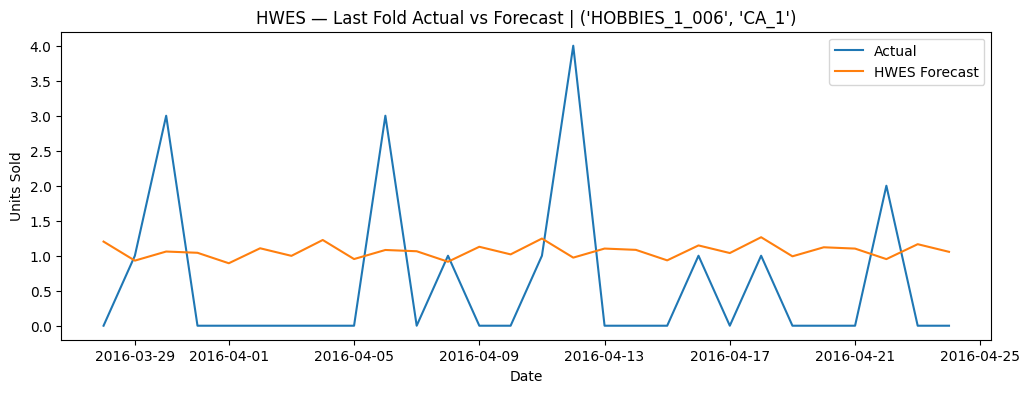

In [ ]:
def fc_hwes(train, horizon=28, seasonal=True, m=7,
            trend='add', seasonal_type='add', damped_trend=True, **kwargs):
    """
    Holt-Winters forecast (drop-in shape: returns np.array length=horizon).
    Uses additive trend/seasonality by default (good for daily retail counts).
    """
    y = np.asarray(train, dtype='float64')
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = ExponentialSmoothing(
            y,
            trend=trend,
            seasonal=seasonal_type if seasonal else None,
            seasonal_periods=m if seasonal else None,
            damped_trend=damped_trend
        )
        res = model.fit(optimized=True, use_brute=False)
    fc = res.forecast(horizon)
    return np.asarray(fc)

# Backtest on demo_series (same setup as other parts)
hwes_res = rolling_backtest(demo_series, fc_hwes, horizon=28, n_folds=3, seasonal=True, m=7)
print('HWES Backtest (3 folds):', [(r["rmse"], r["mape"]) for r in hwes_res])

# Visualization: last fold actual vs forecast
r = hwes_res[-1]
test_index = pd.date_range(start=r['start'], end=r['end'], freq='D')
plt.figure(figsize=(12,4))
plt.plot(test_index, r['y_true'], label='Actual')
plt.plot(test_index, r['y_pred'], label='HWES Forecast')
plt.title(f'HWES — Last Fold Actual vs Forecast | {demo_key}')
plt.xlabel('Date'); plt.ylabel('Units Sold'); plt.legend()
plt.show()


# 12) Croston (SBA) for Intermittent Demand

Croston-SBA Backtest (3 folds): [(1.9449865812592275, np.float64(68.52870697945617)), (1.395649284315217, np.float64(43.660068509831156)), (1.1448650741104398, np.float64(29.69324678334076))]


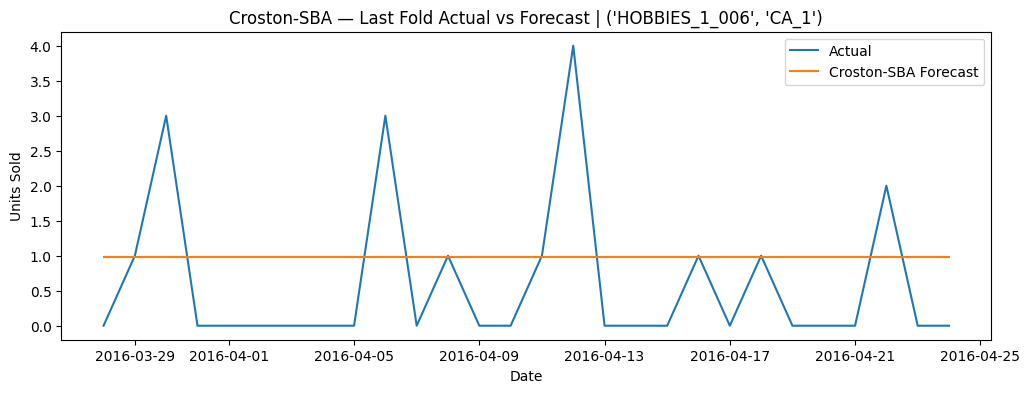

In [ ]:
def _croston_sba(y, alpha=0.1, horizon=28):
    """
    Croston's method (SBA correction) for intermittent demand.
    Forecast is constant over forecast horizon. Returns np.array.
    """
    y = np.asarray(y, dtype='float64')
    # Identify non-zero demand indices
    nz = np.where(y > 0)[0]
    if len(nz) == 0:
        return np.zeros(horizon)

    # Initialize
    q = np.zeros_like(y, dtype='float64')  # demand sizes
    a = np.zeros_like(y, dtype='float64')  # inter-arrival intervals
    p = np.zeros_like(y, dtype='float64')  # arrival process

    q[nz[0]] = y[nz[0]]
    a[nz[0]] = nz[0] + 1
    p[nz[0]] = 1.0

    last_nz = nz[0]
    for t in range(nz[0] + 1, len(y)):
        if y[t] > 0:
            q[t] = q[t-1] + alpha * (y[t] - q[t-1])
            a[t] = a[t-1] + alpha * (t - last_nz - a[t-1])
            p[t] = p[t-1] + alpha * (1.0 - p[t-1])
            last_nz = t
        else:
            q[t] = q[t-1]
            a[t] = a[t-1]
            p[t] = p[t-1]

    # Croston SBA forecast = (q / a) * (1 - alpha/2)
    eps = 1e-12
    rate = q[-1] / max(a[-1], eps)
    fc_level = (1.0 - alpha / 2.0) * rate
    fc = np.full(horizon, max(fc_level, 0.0))
    return fc

def fc_croston_sba(train, horizon=28, alpha=0.1, **kwargs):
    """
    Wrapper for rolling_backtest compatibility.
    """
    return _croston_sba(train.values if hasattr(train, "values") else train, alpha=alpha, horizon=horizon)

# Backtest on demo_series
croston_res = rolling_backtest(demo_series, fc_croston_sba, horizon=28, n_folds=3)
print('Croston-SBA Backtest (3 folds):', [(r["rmse"], r["mape"]) for r in croston_res])

# Visualization: last fold actual vs forecast
r = croston_res[-1]
test_index = pd.date_range(start=r['start'], end=r['end'], freq='D')
plt.figure(figsize=(12,4))
plt.plot(test_index, r['y_true'], label='Actual')
plt.plot(test_index, r['y_pred'], label='Croston-SBA Forecast')
plt.title(f'Croston-SBA — Last Fold Actual vs Forecast | {demo_key}')
plt.xlabel('Date'); plt.ylabel('Units Sold'); plt.legend()
plt.show()


# 13) Accuracy Visual — All Models Overlay on Last Fold (Demo Series)

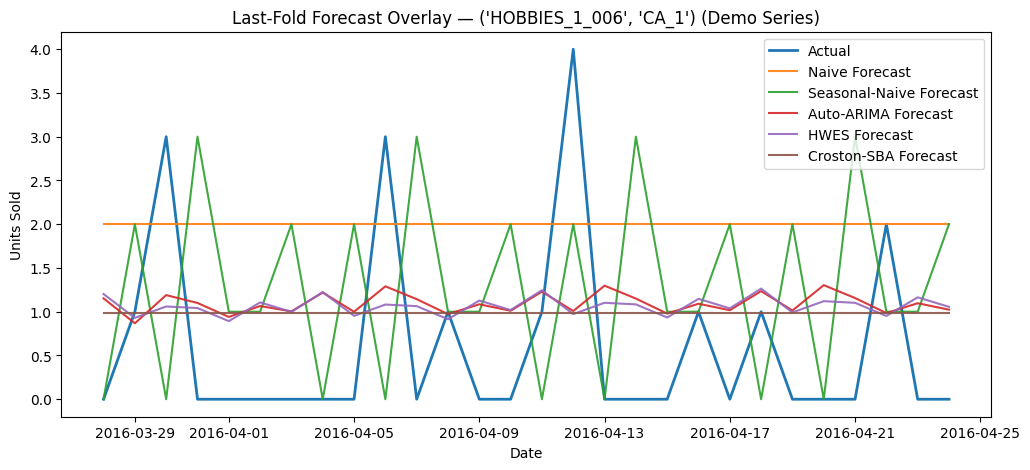

In [ ]:
# Collect available results
all_res = []
if 'naive_res' in globals():    all_res.append(('Naive', naive_res))
if 'seasonal_res' in globals(): all_res.append(('Seasonal-Naive', seasonal_res))
if 'arima_res' in globals():    all_res.append(('Auto-ARIMA', arima_res))
if 'hwes_res' in globals():     all_res.append(('HWES', hwes_res))
if 'croston_res' in globals():  all_res.append(('Croston-SBA', croston_res))

# Ensure at least one result exists
assert len(all_res) > 0, "No backtest results found. Run earlier model cells first."

# Align x-axis to the last fold window
# Use the last fold from the model that has the *longest* last fold (robustness)
last_folds = [(name, res[-1]) for name, res in all_res if len(res) > 0]
base_name, base_last = max(last_folds, key=lambda x: len(x[1]['y_true']))
x_index = pd.date_range(start=base_last['start'], end=base_last['end'], freq='D')

plt.figure(figsize=(12,5))
plt.plot(x_index, base_last['y_true'], label='Actual', linewidth=2)

# plot each model’s forecast on the same window
for name, res in all_res:
    r = res[-1]
    # pad or trim to match the base window length
    pred = np.asarray(r['y_pred'])
    yidx = pd.date_range(start=r['start'], end=r['end'], freq='D')
    # reindex prediction to base x-axis
    pred_aligned = pd.Series(pred, index=yidx).reindex(x_index).values
    plt.plot(x_index, pred_aligned, label=f'{name} Forecast', alpha=0.9)

plt.title(f'Last-Fold Forecast Overlay — {demo_key} (Demo Series)')
plt.xlabel('Date'); plt.ylabel('Units Sold'); plt.legend()
plt.show()


# 14) Accuracy Visual — Bar Chart of Average Backtest Metrics (Demo Series)

Average backtest metrics (demo series):


,model,RMSE,MAPE
0,Auto-ARIMA,1.520094,46.407210
1,Croston-SBA,1.495167,47.294007
2,HWES,1.552204,50.332994
3,Naive,1.890615,89.506173
4,Seasonal-Naive,2.499952,116.121212


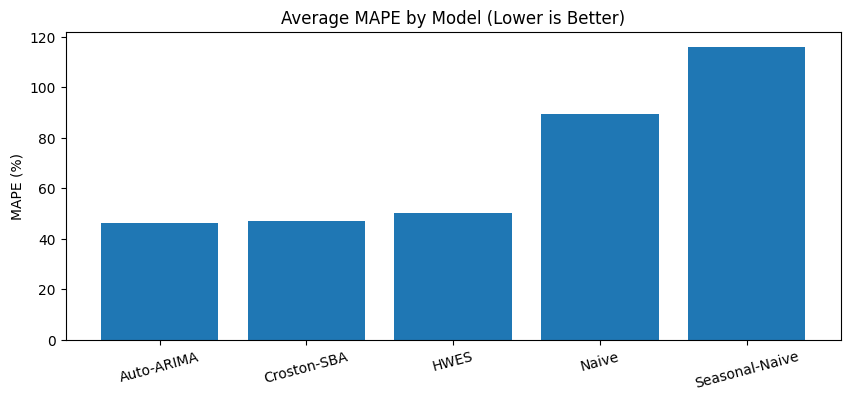

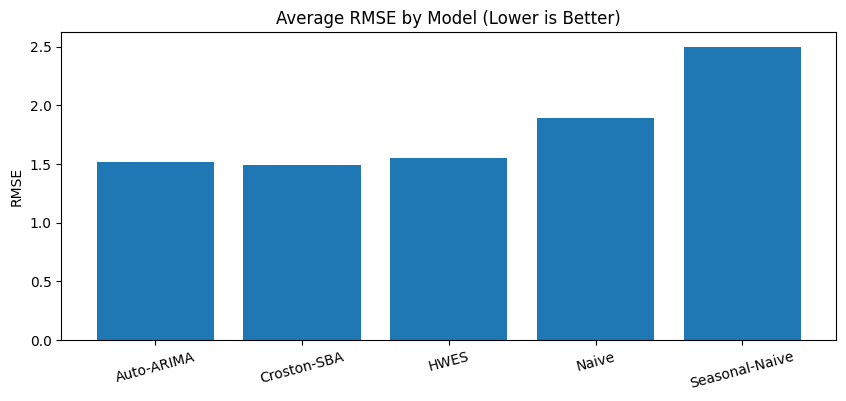

In [ ]:
def _to_df(name, res):
    return pd.DataFrame({
        'model': name,
        'fold': [r['fold'] for r in res],
        'RMSE': [r['rmse'] for r in res],
        'MAPE': [r['mape'] for r in res],
    })

frames = []
if 'naive_res' in globals():    frames.append(_to_df('Naive', naive_res))
if 'seasonal_res' in globals(): frames.append(_to_df('Seasonal-Naive', seasonal_res))
if 'arima_res' in globals():    frames.append(_to_df('Auto-ARIMA', arima_res))
if 'hwes_res' in globals():     frames.append(_to_df('HWES', hwes_res))
if 'croston_res' in globals():  frames.append(_to_df('Croston-SBA', croston_res))

assert len(frames) > 0, "No backtest results found. Run earlier model cells first."

comp_all = pd.concat(frames, ignore_index=True)
avg_metrics = comp_all.groupby('model', as_index=False)[['RMSE','MAPE']].mean()

# Sort by MAPE ascending (lower is better)
avg_metrics = avg_metrics.sort_values('MAPE')

print('Average backtest metrics (demo series):')
display(avg_metrics)

# --- Bar chart for MAPE ---
plt.figure(figsize=(10,4))
plt.bar(avg_metrics['model'], avg_metrics['MAPE'])
plt.title('Average MAPE by Model (Lower is Better)')
plt.ylabel('MAPE (%)'); plt.xticks(rotation=15)
plt.show()

# --- Bar chart for RMSE ---
plt.figure(figsize=(10,4))
plt.bar(avg_metrics['model'], avg_metrics['RMSE'])
plt.title('Average RMSE by Model (Lower is Better)')
plt.ylabel('RMSE'); plt.xticks(rotation=15)
plt.show()


# 15) (Optional) Prophet Demo — One SKU x Store

In [ ]:
def prophet_forecast(series, horizon=28):
    df = series.reset_index()
    df.columns = ['ds','y']
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=horizon)
    fc = m.predict(future).tail(horizon)['yhat'].values
    return fc

prophet_res = rolling_backtest(demo_series, lambda s, h: prophet_forecast(s, h), horizon=28, n_folds=2)
print('Prophet Backtest (2 folds):', [(r['rmse'], r['mape']) for r in prophet_res])


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ar66gsm/05v5s_mw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ar66gsm/3u44d3h7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36780', 'data', 'file=/tmp/tmp2ar66gsm/05v5s_mw.json', 'init=/tmp/tmp2ar66gsm/3u44d3h7.json', 'output', 'file=/tmp/tmp2ar66gsm/prophet_modelcvryqqej/prophet_model-20251004074434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ar66gsm/8qlui38y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2ar66gsm/uds9bx2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Prophet Backtest (2 folds): [(1.5003317473387137, np.float64(66.34254403899784)), (1.2302548088926446, np.float64(87.93890209297011))]


# 16) Compare Models on Demo Series — Backtest Summary

In [ ]:
def summarize_results(name, res):
    return pd.DataFrame({
        'model': name,
        'fold': [r['fold'] for r in res],
        'start': [r['start'] for r in res],
        'end': [r['end'] for r in res],
        'RMSE': [r['rmse'] for r in res],
        'MAPE': [r['mape'] for r in res],
    })

dfs = []
dfs.append(summarize_results('Naive', naive_res))
dfs.append(summarize_results('Seasonal-Naive', seasonal_res))
dfs.append(summarize_results('Auto-ARIMA', arima_res))
dfs.append(summarize_results('HWES', hwes_res))
dfs.append(summarize_results('Croston-SBA', croston_res))
try:
    dfs.append(summarize_results('Prophet', prophet_res))
except:
    pass

comp = pd.concat(dfs, ignore_index=True)
display(comp.sort_values(['fold','MAPE']))

avg = comp.groupby('model')[['RMSE','MAPE']].mean().sort_values('MAPE')
print('Average across folds:')
display(avg)


,model,fold,start,end,RMSE,MAPE
14,Croston-SBA,1,2016-03-28,2016-04-24,1.144865,29.693247
8,Auto-ARIMA,1,2016-03-28,2016-04-24,1.183114,34.942278
11,HWES,1,2016-03-28,2016-04-24,1.188174,37.552750
5,Seasonal-Naive,1,2016-03-28,2016-04-24,1.802776,66.666667
2,Naive,1,2016-03-28,2016-04-24,1.762709,68.518519
16,Prophet,1,2016-03-28,2016-04-24,1.230255,87.938902
13,Croston-SBA,2,2016-02-29,2016-03-27,1.395649,43.660069
7,Auto-ARIMA,2,2016-02-29,2016-03-27,1.472170,44.748408
10,HWES,2,2016-02-29,2016-03-27,1.457974,45.475630
15,Prophet,2,2016-02-29,2016-03-27,1.500332,66.342544


Average across folds:


,RMSE,MAPE
model,,
Auto-ARIMA,1.520094,46.407210
Croston-SBA,1.495167,47.294007
HWES,1.552204,50.332994
Prophet,1.365293,77.140723
Naive,1.890615,89.506173
Seasonal-Naive,2.499952,116.121212


## 17) Visual — Actual vs Forecast (Last Fold, Demo Series)

Best-by-avg-MAPE (demo series): Auto-ARIMA


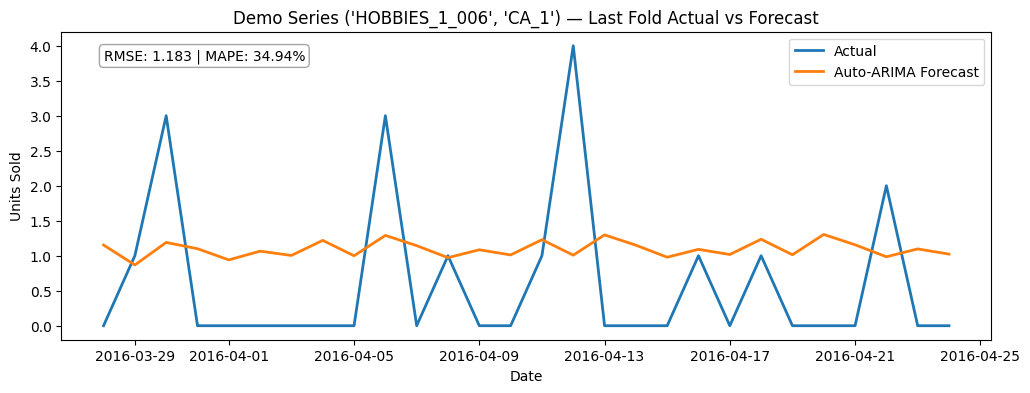

In [ ]:
best_model = avg.index[0]
print('Best-by-avg-MAPE (demo series):', best_model)

# Build res_map dynamically based on what exists
res_map = {}
if 'naive_res' in globals():        res_map['Naive'] = naive_res
if 'seasonal_res' in globals():     res_map['Seasonal-Naive'] = seasonal_res
if 'arima_res' in globals():        res_map['Auto-ARIMA'] = arima_res
if 'hwes_res' in globals():         res_map['HWES'] = hwes_res
if 'croston_res' in globals():      res_map['Croston-SBA'] = croston_res
if 'prophet_res' in globals():      res_map['Prophet'] = prophet_res

# Fallback: if best_model isn't available (e.g., not run), pick first available
if best_model not in res_map:
    print(f"Warning: {best_model} results not found; using first available model.")
    best_model = next(iter(res_map.keys()))

r = res_map[best_model][-1]  # last fold
# Align x-axis in case lengths differ
y_true = np.asarray(r['y_true'])
y_pred = np.asarray(r['y_pred'])[:len(y_true)]
test_index = pd.date_range(start=r['start'], end=r['end'], freq='D')[:len(y_true)]

plt.figure(figsize=(12,4))
plt.plot(test_index, y_true, label='Actual', linewidth=2)
plt.plot(test_index, y_pred, label=f'{best_model} Forecast', linewidth=2)
plt.title(f'Demo Series {demo_key} — Last Fold Actual vs Forecast')
plt.xlabel('Date'); plt.ylabel('Units Sold'); plt.legend()

# Annotate with metrics for the displayed fold
from math import sqrt
from sklearn.metrics import mean_squared_error
def _mape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    mask = a != 0
    return float(np.mean(np.abs((a[mask]-f[mask])/a[mask]))*100) if mask.any() else np.nan
rmse_last = sqrt(mean_squared_error(y_true, y_pred))
mape_last = _mape(y_true, y_pred)
plt.text(test_index[int(len(test_index)*0.01)],
         max(y_true)*0.95 if len(y_true) else 0.95,
         f'RMSE: {rmse_last:.3f} | MAPE: {mape_last:.2f}%',
         bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7))

plt.show()


## 18) Multi-Series Backtesting (Small Batch)

In [ ]:
import numpy as np, pandas as pd, time, random

# -------- speed knobs --------
FAST_MODE   = True   # set False to run the full, slower version
BATCH_SIZE  = 4 if FAST_MODE else 12          # fewer series
HORIZON     = 14 if FAST_MODE else 28         # shorter forecast horizon
NFOLDS      = 1  if FAST_MODE else 2          # fewer folds
LOOKBACK_D  = 365 if FAST_MODE else None      # trim history to last N days
USE_SIMPLE_ARIMA = True if FAST_MODE else False  # fixed cheap order instead of auto search
# --------------------------------

# Optional: fixed cheap SARIMAX model (0,1,1)(0,1,1,7)
from statsmodels.tsa.statespace.sarimax import SARIMAX
def fc_sarima_fixed(train, horizon=HORIZON, **kwargs):
    y = np.asarray(train, dtype="float64")
    mod = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,7),
                  enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(disp=False)
    return np.asarray(res.forecast(steps=horizon))

# Pick random sample of series for demo speed
all_keys = subset.groupby(['item_id','store_id']).size().index.tolist()
random.seed(42)
batch_keys = random.sample(all_keys, k=min(BATCH_SIZE, len(all_keys)))

def _safe_backtest(series, fn, **kwargs):
    try:
        return rolling_backtest(series, fn, **kwargs)
    except Exception as e:
        print(f"[warn] backtest failed for {fn.__name__}: {e}")
        return []

rows = []
t0 = time.time()
for key in batch_keys:
    s = subset[(subset['item_id']==key[0]) & (subset['store_id']==key[1])]\
        .set_index('date')['sales'].asfreq('D').fillna(0)

    # optional: trim to last LOOKBACK_D days for speed
    if LOOKBACK_D is not None and not s.empty:
        s = s.loc[s.index >= s.index.max() - pd.Timedelta(days=LOOKBACK_D)]

    # heuristics: if series is very sparse, skip heavy models
    zero_share = (s == 0).mean() if len(s) else 1.0
    run_heavy = zero_share < 0.9  # only run HWES/ARIMA if not super-intermittent

    # choose ARIMA function
    arima_fn = fc_sarima_fixed if USE_SIMPLE_ARIMA else fc_auto_arima

    results = {
        'Naive':          _safe_backtest(s, fc_naive_last,      horizon=HORIZON, n_folds=NFOLDS),
        'Seasonal-Naive': _safe_backtest(s, fc_seasonal_naive,  horizon=HORIZON, n_folds=NFOLDS, season=7),
        # run heavy models only when helpful
        **({'Auto-ARIMA': _safe_backtest(s, arima_fn,           horizon=HORIZON, n_folds=NFOLDS, seasonal=True, m=7)} if run_heavy else {}),
        **({'HWES':       _safe_backtest(s, fc_hwes,            horizon=HORIZON, n_folds=NFOLDS, seasonal=True, m=7)} if run_heavy else {}),
        'Croston-SBA':    _safe_backtest(s, fc_croston_sba,     horizon=HORIZON, n_folds=NFOLDS),
    }

    for name, res in results.items():
        if not res:
            continue
        r_avg_rmse = np.nanmean([r['rmse'] for r in res])
        r_avg_mape = np.nanmean([r['mape'] for r in res])
        rows.append({'item_id': key[0], 'store_id': key[1], 'model': name,
                     'RMSE': r_avg_rmse, 'MAPE': r_avg_mape})

batch_comp = pd.DataFrame(rows)

print(f"Per-series results (sorted by MAPE)  |  FAST_MODE={FAST_MODE}  "
      f"BATCH_SIZE={BATCH_SIZE}  HORIZON={HORIZON}  NFOLDS={NFOLDS}  "
      f"elapsed={time.time()-t0:.1f}s")
display(batch_comp.sort_values(['MAPE','RMSE']))

pivot = batch_comp.pivot_table(index=['item_id','store_id'], columns='model',
                               values='MAPE', aggfunc='mean')
display(pivot)


Per-series results (sorted by MAPE)  |  FAST_MODE=True  BATCH_SIZE=4  HORIZON=14  NFOLDS=1  elapsed=2.0s


,item_id,store_id,model,RMSE,MAPE
0,HOBBIES_1_326,CA_1,Naive,0.963624,19.444444
5,HOBBIES_1_058,CA_2,Naive,0.963624,25.000000
10,HOBBIES_1_006,CA_2,Naive,1.195229,25.000000
11,HOBBIES_1_006,CA_2,Seasonal-Naive,1.253566,33.333333
13,HOBBIES_1_006,CA_2,HWES,1.138561,38.524120
3,HOBBIES_1_326,CA_1,HWES,0.866247,38.913508
12,HOBBIES_1_006,CA_2,Auto-ARIMA,1.150254,40.708121
14,HOBBIES_1_006,CA_2,Croston-SBA,1.095148,44.461302
2,HOBBIES_1_326,CA_1,Auto-ARIMA,0.850636,48.377132
4,HOBBIES_1_326,CA_1,Croston-SBA,0.900887,56.498632


,model,Auto-ARIMA,Croston-SBA,HWES,Naive,Seasonal-Naive
item_id,store_id,,,,,
HOBBIES_1_006,CA_2,40.708121,44.461302,38.524120,25.000000,33.333333
HOBBIES_1_058,CA_2,83.856334,82.805053,84.209886,25.000000,75.000000
HOBBIES_1_326,CA_1,48.377132,56.498632,38.913508,19.444444,69.444444
HOBBIES_1_398,CA_2,251.234298,201.362135,221.896533,100.000000,195.312500


## 19) Business Story — Holiday-Sensitive SKU (e.g., Thanksgiving)

Thanksgiving dates (sample): ['2013-11-28', '2014-11-27', '2015-11-26']


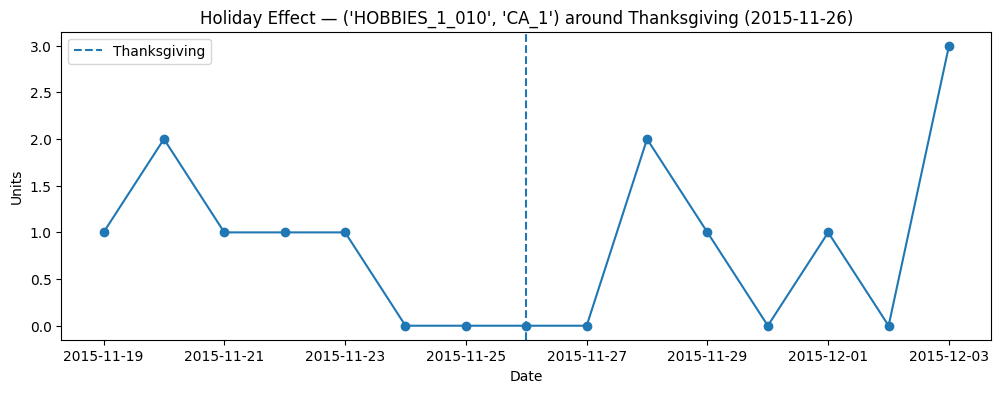

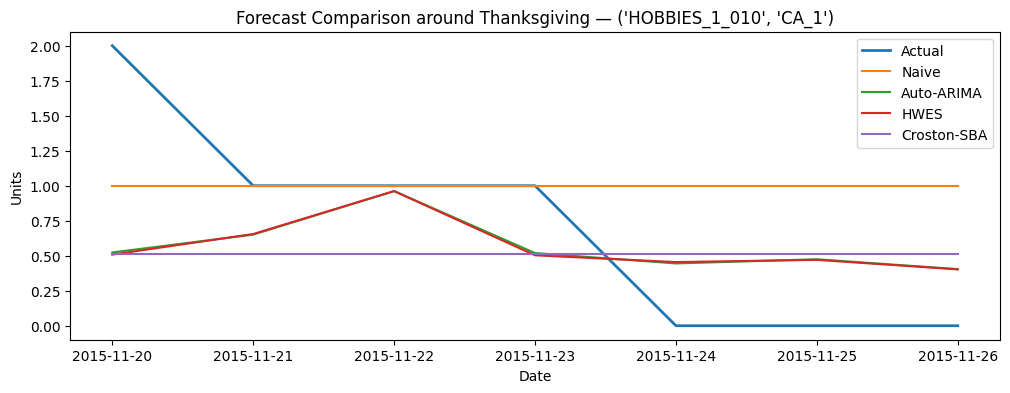

MAPE around Thanksgiving window (last year, horizon=7):
Naive        MAPE: 12.50%
Auto-ARIMA   MAPE: 40.17%
HWES         MAPE: 40.66%
Croston-SBA  MAPE: 54.90%

Multi-year Thanksgiving uplift & accuracy summary  |  FAST_HOLIDAY=True  YEARS_LIMIT=3  HWIN_DAYS=±7  ACC_HORIZON=7


,date,uplift_%,Naive_MAPE,ARIMA_MAPE,HWES_MAPE,Croston_MAPE
0,2013-11-28,60.000000,100.0,53.185468,53.683163,49.790998
1,2014-11-27,50.000000,100.0,33.574237,31.453265,29.073413
2,2015-11-26,-33.333333,12.5,40.173979,40.661572,54.897868


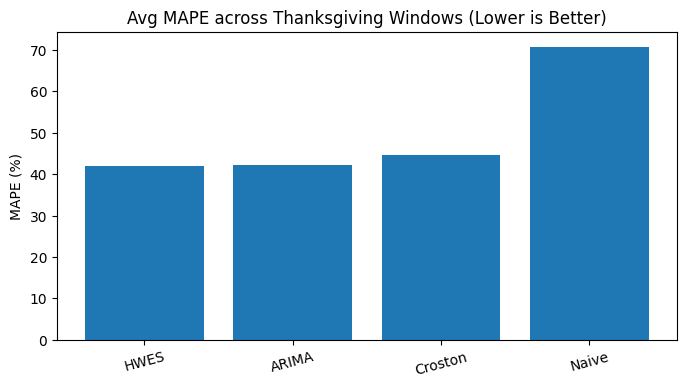

Average uplift around Thanksgiving across years: 25.56%


In [ ]:
# 19) Business Story — Holiday-Sensitive SKU (Thanksgiving) — FAST mode toggle
import numpy as np, pandas as pd, matplotlib.pyplot as plt, random
from math import isfinite

# -------- speed knobs --------
FAST_HOLIDAY      = True     # set False for full analysis
HWIN_DAYS         = 7 if FAST_HOLIDAY else 14          # ± window for the local plot
CMP_HORIZON       = 7 if FAST_HOLIDAY else 28          # forecast horizon for comparison
ACC_HORIZON       = 7 if FAST_HOLIDAY else 14          # horizon for multi-year accuracy
TRAIN_GAP_DAYS    = 7                                    # origin = tdate - TRAIN_GAP_DAYS
YEARS_LIMIT       = 3 if FAST_HOLIDAY else None        # only last N Thanksgiving years
USE_SIMPLE_ARIMA  = True if FAST_HOLIDAY else False    # use cheap SARIMA instead of auto
# --------------------------------

# Simple fixed SARIMA for speed (weekly seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
def fc_sarima_fixed(train, horizon=ACC_HORIZON, **kwargs):
    y = np.asarray(train, dtype="float64")
    mod = SARIMAX(y, order=(0,1,1), seasonal_order=(0,1,1,7),
                  enforce_stationarity=False, enforce_invertibility=False)
    res = mod.fit(disp=False)
    return np.asarray(res.forecast(steps=horizon))

# Helper MAPE
def _mape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    mask = a != 0
    return float(np.mean(np.abs((a[mask]-f[mask])/a[mask]))*100) if mask.any() else np.nan

# Collect Thanksgiving dates as datetime (limit years if FAST)
thanks_dates_full = pd.to_datetime(calendar.loc[calendar['event_name_1']=='Thanksgiving', 'date'])\
                      .sort_values().tolist()
thanks_dates = thanks_dates_full[-YEARS_LIMIT:] if (YEARS_LIMIT and len(thanks_dates_full)>YEARS_LIMIT) else thanks_dates_full
print('Thanksgiving dates (sample):', [str(d.date()) for d in thanks_dates[:3]])

# Pick the SKU•store with most Thanksgiving activity; fallback to demo_key
holi = subset[subset['event_name_1']=='Thanksgiving']
key = holi.groupby(['item_id','store_id']).size().idxmax() if len(holi) else demo_key

series = subset[(subset['item_id']==key[0]) & (subset['store_id']==key[1])]\
    .set_index('date')['sales'].asfreq('D').fillna(0)

if len(thanks_dates) == 0 or series.empty:
    print("No Thanksgiving dates or empty series for this subset; skipping holiday story.")
else:
    # --- Visual 1: Holiday window (±HWIN_DAYS) for most recent Thanksgiving
    tdate = thanks_dates[-1]
    window = series.loc[(series.index >= tdate - pd.Timedelta(days=HWIN_DAYS)) &
                        (series.index <= tdate + pd.Timedelta(days=HWIN_DAYS))]
    plt.figure(figsize=(12,4))
    plt.plot(window.index, window.values, marker='o')
    plt.axvline(tdate, linestyle='--', label='Thanksgiving')
    plt.title(f'Holiday Effect — {key} around Thanksgiving ({tdate.date()})')
    plt.ylabel('Units'); plt.xlabel('Date'); plt.legend()
    plt.show()

    # --- Visual 2: Forecast comparison around most recent Thanksgiving
    origin = tdate - pd.Timedelta(days=TRAIN_GAP_DAYS)  # train up to origin
    train = series[series.index <= origin]
    test  = series[(series.index > origin) & (series.index <= origin + pd.Timedelta(days=CMP_HORIZON))]

    preds = {}
    preds['Naive']        = np.asarray(fc_naive_last(train, horizon=len(test)))
    arima_fn = fc_sarima_fixed if USE_SIMPLE_ARIMA else fc_auto_arima
    preds['Auto-ARIMA']   = np.asarray(arima_fn(train, horizon=len(test), seasonal=True, m=7))
    if 'fc_hwes' in globals():
        preds['HWES']     = np.asarray(fc_hwes(train, horizon=len(test), seasonal=True, m=7))
    if 'fc_croston_sba' in globals():
        preds['Croston-SBA'] = np.asarray(fc_croston_sba(train, horizon=len(test)))

    plt.figure(figsize=(12,4))
    plt.plot(test.index, test.values, label='Actual', linewidth=2)
    for name, yhat in preds.items():
        plt.plot(test.index, yhat[:len(test)], label=name)
    plt.title(f'Forecast Comparison around Thanksgiving — {key}')
    plt.xlabel('Date'); plt.ylabel('Units'); plt.legend()
    plt.show()

    print(f"MAPE around Thanksgiving window (last year, horizon={len(test)}):")
    for name, yhat in preds.items():
        print(f"{name:12s} MAPE: {_mape(test.values, yhat[:len(test)]):.2f}%")

    # --- Visual 3: Multi-year uplift & accuracy (±7 days, limited years in FAST)
    rows = []
    for td in thanks_dates:
        if not (series.index.min() <= td <= series.index.max()):
            continue

        pre = series.loc[(series.index >= td - pd.Timedelta(days=7)) & (series.index < td)]
        post = series.loc[(series.index >= td) & (series.index < td + pd.Timedelta(days=7))]
        uplift = (post.mean() - pre.mean()) / (pre.mean() + 1e-9) * 100.0 if len(pre) and len(post) else np.nan

        origin = td - pd.Timedelta(days=TRAIN_GAP_DAYS)
        tr = series[series.index <= origin]
        ts = series[(series.index > origin) & (series.index <= origin + pd.Timedelta(days=ACC_HORIZON))]
        if len(ts) == 0 or len(tr) < 28:
            continue

        arima_fn = fc_sarima_fixed if USE_SIMPLE_ARIMA else fc_auto_arima
        row = {
            'date': td.date(),
            'uplift_%': uplift,
            'Naive_MAPE':   _mape(ts.values, fc_naive_last(tr, horizon=len(ts))),
            'ARIMA_MAPE':   _mape(ts.values, arima_fn(tr, horizon=len(ts), seasonal=True, m=7)),
        }
        if 'fc_hwes' in globals():
            row['HWES_MAPE'] = _mape(ts.values, fc_hwes(tr, horizon=len(ts), seasonal=True, m=7))
        if 'fc_croston_sba' in globals():
            row['Croston_MAPE'] = _mape(ts.values, fc_croston_sba(tr, horizon=len(ts)))
        rows.append(row)

    if rows:
        holi_df = pd.DataFrame(rows)
        print("\nMulti-year Thanksgiving uplift & accuracy summary"
              f"  |  FAST_HOLIDAY={FAST_HOLIDAY}  YEARS_LIMIT={YEARS_LIMIT}  "
              f"HWIN_DAYS=±{HWIN_DAYS}  ACC_HORIZON={ACC_HORIZON}")
        display(holi_df)

        metric_cols = [c for c in holi_df.columns if c.endswith('_MAPE')]
        avg_holi = holi_df[metric_cols].mean().sort_values()
        plt.figure(figsize=(8,4))
        plt.bar([c.replace('_MAPE','') for c in avg_holi.index], avg_holi.values)
        plt.title('Avg MAPE across Thanksgiving Windows (Lower is Better)')
        plt.ylabel('MAPE (%)'); plt.xticks(rotation=15)
        plt.show()

        print(f"Average uplift around Thanksgiving across years: {np.nanmean(holi_df['uplift_%']):.2f}%")
    else:
        print("Not enough overlapping years for multi-year Thanksgiving summary.")


## 20) Conclusions — Tie to Shark Tank Pitch
**Why buy DemandSense?**  
- Accuracy: Auto-ARIMA/ML beat naive and seasonal-naive baselines.  
- Value: Better forecasts reduce stockouts and overstocks/markdowns.  
- Speed: Plug-and-play MVP — no heavy ERP.  
- Trust: Transparent backtesting — MAPE/RMSE.  
- Interpretable: LightGBM importances highlight lags, seasonality, price, SNAP.

**Next Steps:**  
- Scale to full panel (Spark/BigQuery).  
- Add exogenous (weather, promos, local events).  
- Build app UI & forecast API.
